# Compare performance with denoising

In [3]:
import time
import pymysql
import pandas as pd
%matplotlib inline

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

from scipy.stats import pearsonr
import torch.nn as nn

from sklearn.metrics import mean_squared_error

### Load data

In [4]:
conn = pymysql.connect(host='localhost', port=3306, user='root', password='pw', db='data_test', charset='utf8')
cur = conn.cursor()

In [5]:
sensor_data = pd.read_sql("select * from sensor_data", conn)
sensor_data

,data_id,created_at,input_data,ss_id,pos_name,type_name
0,221234,2022-10-11 14:04:55,3038.0,9,HR,TVOC
1,221227,2022-10-11 14:04:55,487.0,2,HR,CO2
2,221233,2022-10-11 14:04:55,10.0,8,HR,PM10
3,221228,2022-10-11 14:04:55,19.4,3,HR,온도
4,221231,2022-10-11 14:04:55,10.0,6,HR,PM2.5
...,...,...,...,...,...,...
155670,65363,2022-04-30 23:55:49,10.0,7,HR,PM4.0
155671,65365,2022-04-30 23:55:49,812.0,9,HR,TVOC
155672,65364,2022-04-30 23:55:49,10.0,8,HR,PM10
155673,65361,2022-04-30 23:55:49,10.0,5,HR,PM1.0


In [6]:
## HR
# 이산화탄소 센서
co2_data = sensor_data.loc[sensor_data['ss_id']==2]
# 온도 센서
temp_data = sensor_data.loc[sensor_data['ss_id']==3]
# 습도 센서
humid_data = sensor_data.loc[sensor_data['ss_id']==4]
# PM1.0 센서
pm1_data = sensor_data.loc[sensor_data['ss_id']==5]
# PM2.5 센서
pm2_data = sensor_data.loc[sensor_data['ss_id']==6]
# PM4.0 센서
pm4_data = sensor_data.loc[sensor_data['ss_id']==7]
# PM10 센서
pm10_data = sensor_data.loc[sensor_data['ss_id']==8]
# TVOC 센서
tvoc_data = sensor_data.loc[sensor_data['ss_id']==9]
col_list = list(co2_data.columns)
col_list[2] = 'co2_data'
co2_data.columns = col_list
col_list = list(temp_data.columns)
col_list[2] = 'temp_data'
temp_data.columns = col_list
col_list = list(humid_data.columns)
col_list[2] = 'humid_data'
humid_data.columns = col_list
col_list = list(pm1_data.columns)
col_list[2] = 'pm1_data'
pm1_data.columns = col_list
col_list = list(pm2_data.columns)
col_list[2] = 'pm2_data'
pm2_data.columns = col_list
col_list = list(pm4_data.columns)
col_list[2] = 'pm4_data'
pm4_data.columns = col_list
col_list = list(pm10_data.columns)
col_list[2] = 'pm10_data'
pm10_data.columns = col_list
col_list = list(tvoc_data.columns)
col_list[2] = 'tvoc_data'
tvoc_data.columns = col_list

In [7]:
hr_sensor_data = pd.merge(left=co2_data, right=temp_data, how="inner", on="created_at")
hr_sensor_data = pd.merge(left=hr_sensor_data, right=humid_data, how="inner", on="created_at")
hr_sensor_data = pd.merge(left=hr_sensor_data, right=pm1_data, how="inner", on="created_at")
hr_sensor_data = pd.merge(left=hr_sensor_data, right=pm2_data, how="inner", on="created_at")
hr_sensor_data = pd.merge(left=hr_sensor_data, right=pm4_data, how="inner", on="created_at")
hr_sensor_data = pd.merge(left=hr_sensor_data, right=pm10_data, how="inner", on="created_at")
hr_sensor_data = pd.merge(left=hr_sensor_data, right=tvoc_data, how="inner", on="created_at")

hr_sensor_data = hr_sensor_data[["created_at","co2_data","temp_data","humid_data","pm10_data","tvoc_data"]]
hr_sensor_data = hr_sensor_data.sort_values(by=['created_at'],ascending=True)

/Users/seohyun/Desktop/KHU/capstone2/code/python-data-control/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Passing 'suffixes' which cause duplicate columns {'pos_name_x', 'ss_id_x', 'data_id_x', 'type_name_x'} in the result is deprecated and will raise a MergeError in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/seohyun/Desktop/KHU/capstone2/code/python-data-control/venv/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Passing 'suffixes' which cause duplicate columns {'pos_name_x', 'ss_id_x', 'data_id_x', 'type_name_x'} in the result is deprecated and will raise a MergeError in a future version.
  """
/Users/seohyun/Desktop/KHU/capstone2/code/python-data-control/venv/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Passing 'suffixes' which cause duplicate columns {'pos_name_x', 'ss_id_x', 'data_id_x', 'type_name_x'} in the result is deprecated and will raise a

In [8]:
hr_sensor_data_value = hr_sensor_data[["co2_data","temp_data","humid_data","pm10_data","tvoc_data"]]
hr_sensor_data_value.index=hr_sensor_data["created_at"]
hr_sensor_data_value

,co2_data,temp_data,humid_data,pm10_data,tvoc_data
created_at,,,,,
2022-05-01 00:05:49,390.0,27.5,26.6,10.0,780.0
2022-05-01 00:15:49,390.0,27.5,26.5,9.0,785.0
2022-05-01 00:25:49,389.0,27.6,26.5,9.0,805.0
2022-05-01 00:35:49,396.0,27.6,26.4,9.0,808.0
2022-05-01 00:45:49,390.0,27.6,26.4,9.0,793.0
...,...,...,...,...,...
2022-10-11 13:24:55,488.0,19.4,48.0,11.0,2344.0
2022-10-11 13:34:55,479.0,19.4,47.8,11.0,2337.0
2022-10-11 13:44:55,479.0,19.4,50.3,11.0,3061.0


In [11]:
# to csv
drop_dup = hr_sensor_data.drop_duplicates(['created_at'])
drop_dup.to_csv('hr_sensor_data.csv', index=False)

<AxesSubplot:xlabel='created_at'>

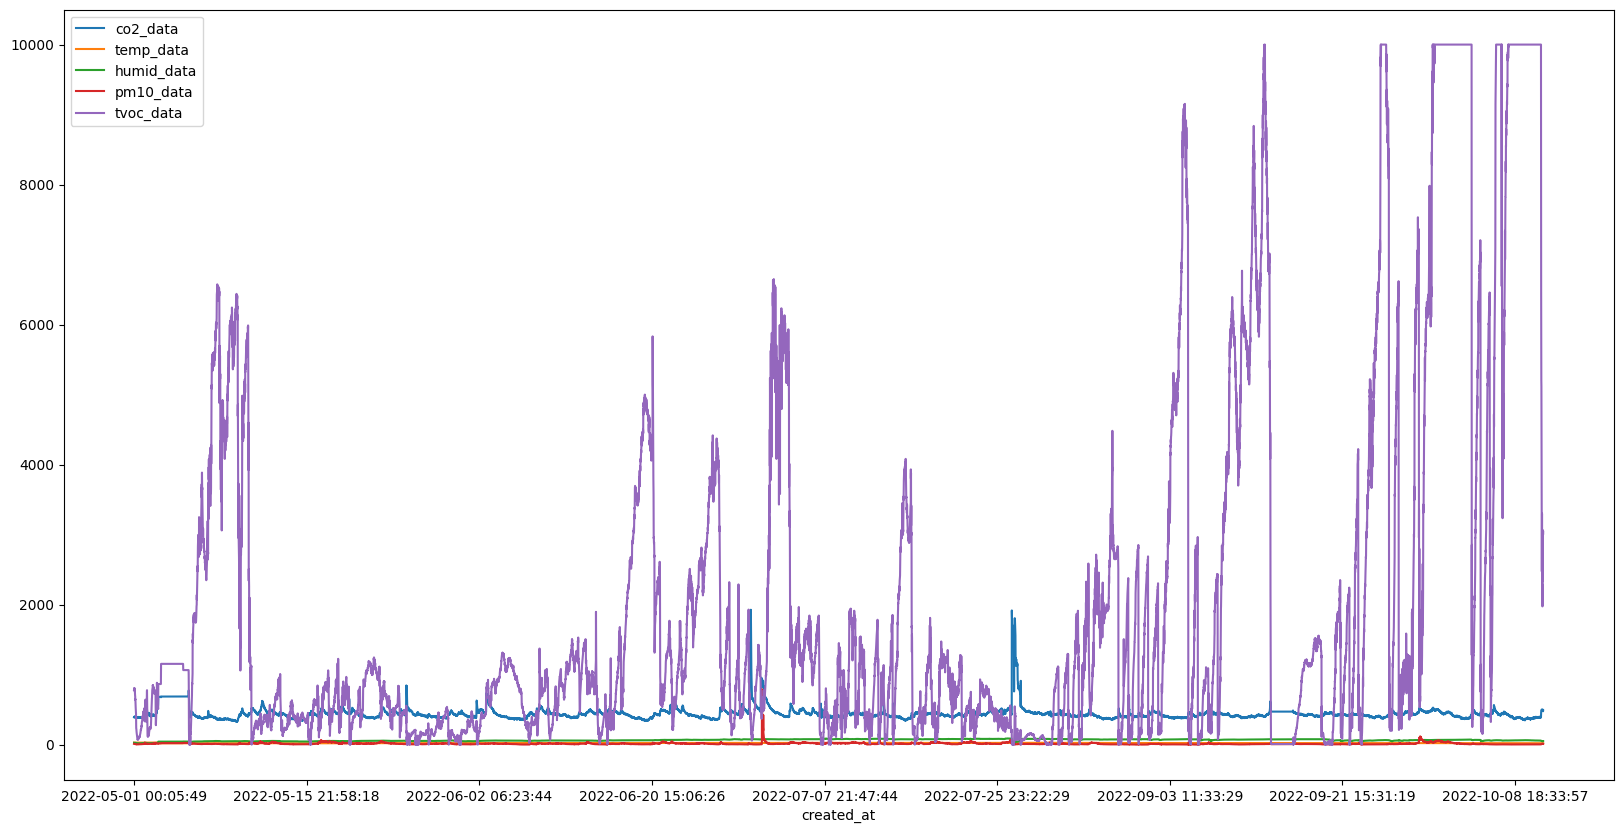

In [7]:
hr_sensor_data_value.plot(figsize=(20,10))

## Before Denoising

### Pearson correlation

In [8]:
print("co2 & temperature: {}".format(pearsonr(hr_sensor_data_value['co2_data'],hr_sensor_data_value['temp_data'])[0]))
print("co2 & humidity: {}".format(pearsonr(hr_sensor_data_value['co2_data'],hr_sensor_data_value['humid_data'])[0]))
print("co2 & pm10: {}".format(pearsonr(hr_sensor_data_value['co2_data'],hr_sensor_data_value['pm10_data'])[0]))
print("co2 & tvoc: {}".format(pearsonr(hr_sensor_data_value['co2_data'],hr_sensor_data_value['tvoc_data'])[0]))
print("temperature & humidity: {}".format(pearsonr(hr_sensor_data_value['temp_data'],hr_sensor_data_value['humid_data'])[0]))
print("temperature & pm10: {}".format(pearsonr(hr_sensor_data_value['temp_data'],hr_sensor_data_value['pm10_data'])[0]))
print("temperature & tvoc: {}".format(pearsonr(hr_sensor_data_value['temp_data'],hr_sensor_data_value['tvoc_data'])[0]))
print("humidity & pm10: {}".format(pearsonr(hr_sensor_data_value['humid_data'],hr_sensor_data_value['pm10_data'])[0]))
print("humidity & tvoc: {}".format(pearsonr(hr_sensor_data_value['humid_data'],hr_sensor_data_value['tvoc_data'])[0]))
print("pm10 & tvoc: {}".format(pearsonr(hr_sensor_data_value['pm10_data'],hr_sensor_data_value['tvoc_data'])[0]))


co2 & temperature: 0.12736644450869294
co2 & humidity: -0.11731121732579844
co2 & pm10: 0.23466366445416298
co2 & tvoc: -0.20780741376431877
temperature & humidity: 0.5400348864462136
temperature & pm10: -0.007943860091535231
temperature & tvoc: -0.2240637789866463
humidity & pm10: 0.03955560928989581
humidity & tvoc: 0.05807406570667886
pm10 & tvoc: -0.07137888494057998


## After denoising

In [9]:
def fft_denoiser(x, n_components, to_real=True):
    """Fast fourier transform denoiser.
    
    Denoises data using the fast fourier transform.
    
    Parameters
    ----------
    x : numpy.array
        The data to denoise.
    n_components : int
        The value above which the coefficients will be kept.
    to_real : bool, optional, default: True
        Whether to remove the complex part (True) or not (False)
        
    Returns
    -------
    clean_data : numpy.array
        The denoised data.
        
    References
    ----------
    .. [1] Steve Brunton - Denoising Data with FFT[Python]
       https://www.youtube.com/watch?v=s2K1JfNR7Sc&ab_channel=SteveBrunton
    
    """
    n = len(x)
    
    # compute the fft
    fft = np.fft.fft(x, n)
    
    # compute power spectrum density
    # squared magnitud of each fft coefficient
    PSD = fft * np.conj(fft) / n
    
    # keep high frequencies
    _mask = PSD > n_components
    fft = _mask * fft
    
    # inverse fourier transform
    clean_data = np.fft.ifft(fft)
    
    if to_real:
        clean_data = clean_data.real
    
    return clean_data

In [10]:
# # co2 data
# co2_data_denoised = fft_denoiser(hr_sensor_data_value['co2_data'].to_numpy(), 10000)
# co2_data_denoised = pd.DataFrame(co2_data_denoised)
# co2_data_denoised.index = hr_sensor_data["created_at"]
# co2_data_denoised_df = hr_sensor_data_value['co2_data'].to_frame()
# co2_data_denoised_df['co2_data_denoised'] = co2_data_denoised[0]
# co2_data_denoised_df.plot(figsize=(30,10))

In [11]:
hr_sensor_data_value_denoised = hr_sensor_data_value

In [12]:
com = 50

<AxesSubplot:xlabel='created_at'>

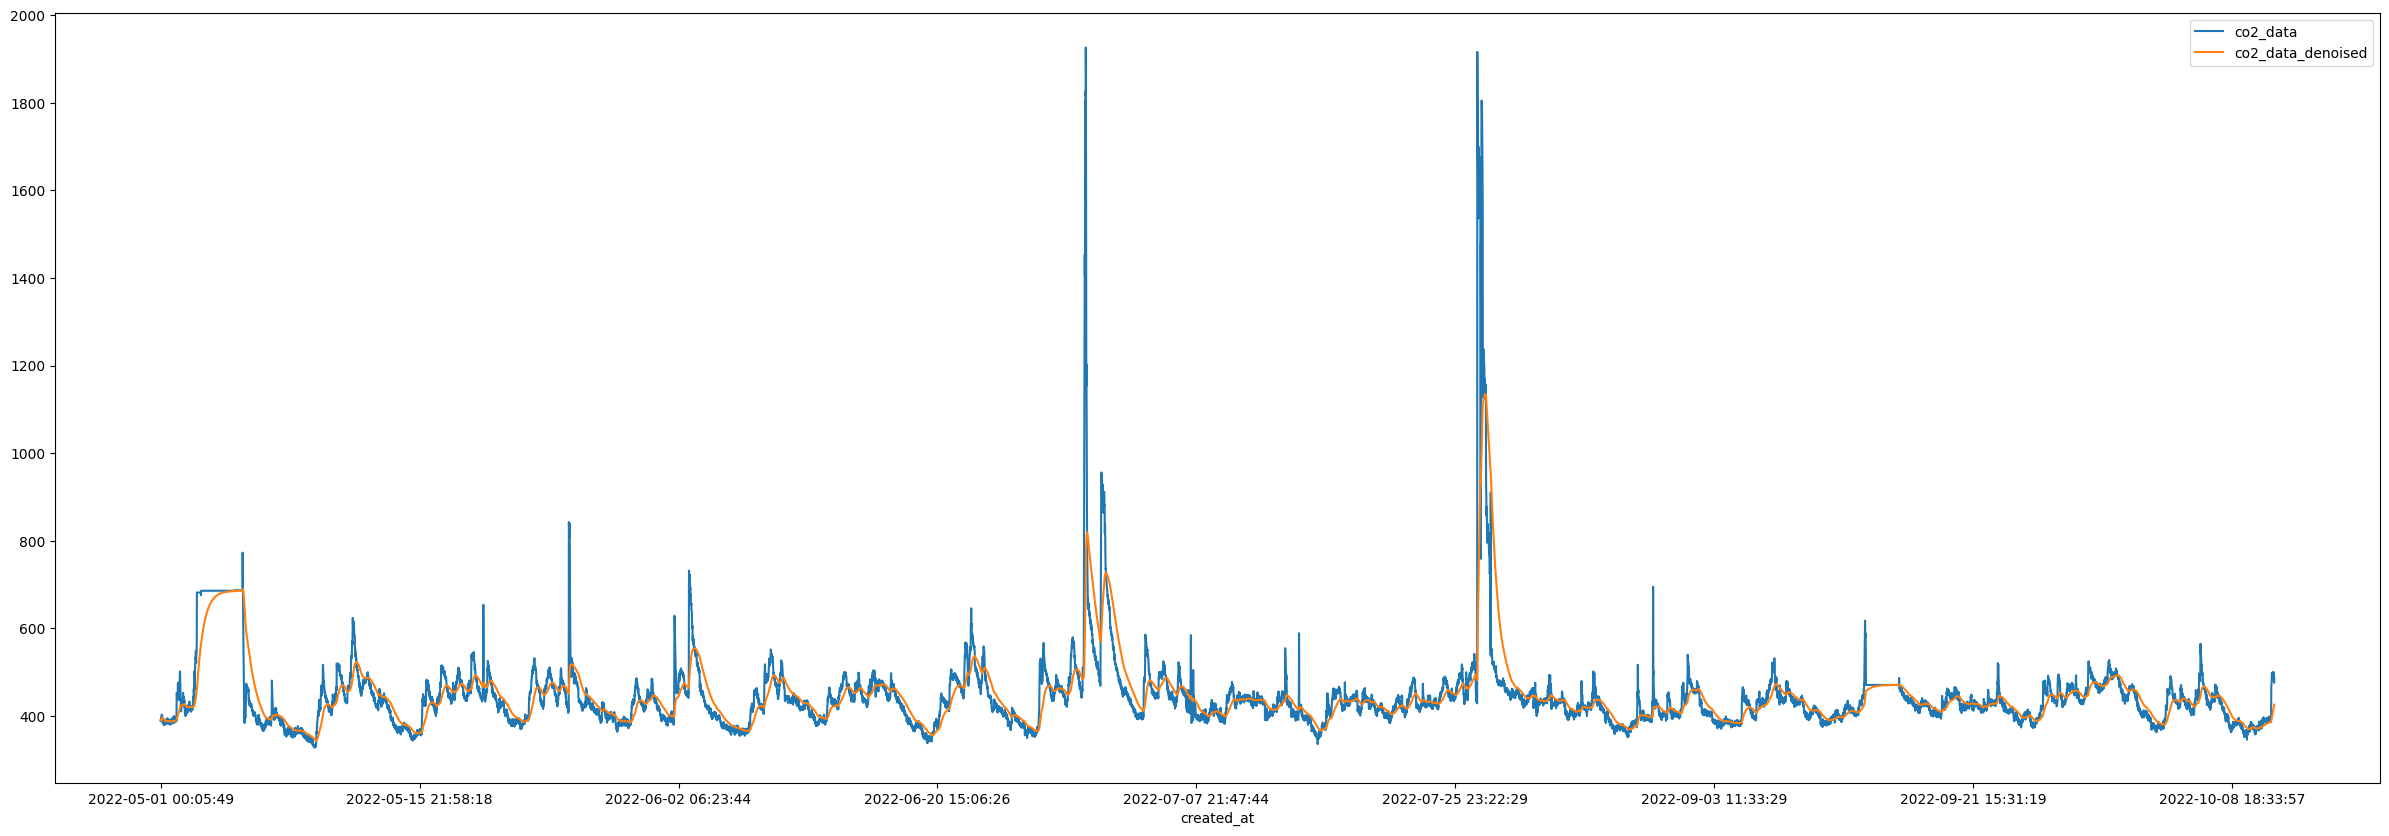

In [13]:
# co2 data
ema = pd.DataFrame(hr_sensor_data_value['co2_data']).ewm(com).mean()
hr_sensor_data_value_denoised['co2_data_denoised'] = ema['co2_data']
hr_sensor_data_value_denoised.plot(y=['co2_data', 'co2_data_denoised'], figsize=(30,10))

<AxesSubplot:xlabel='created_at'>

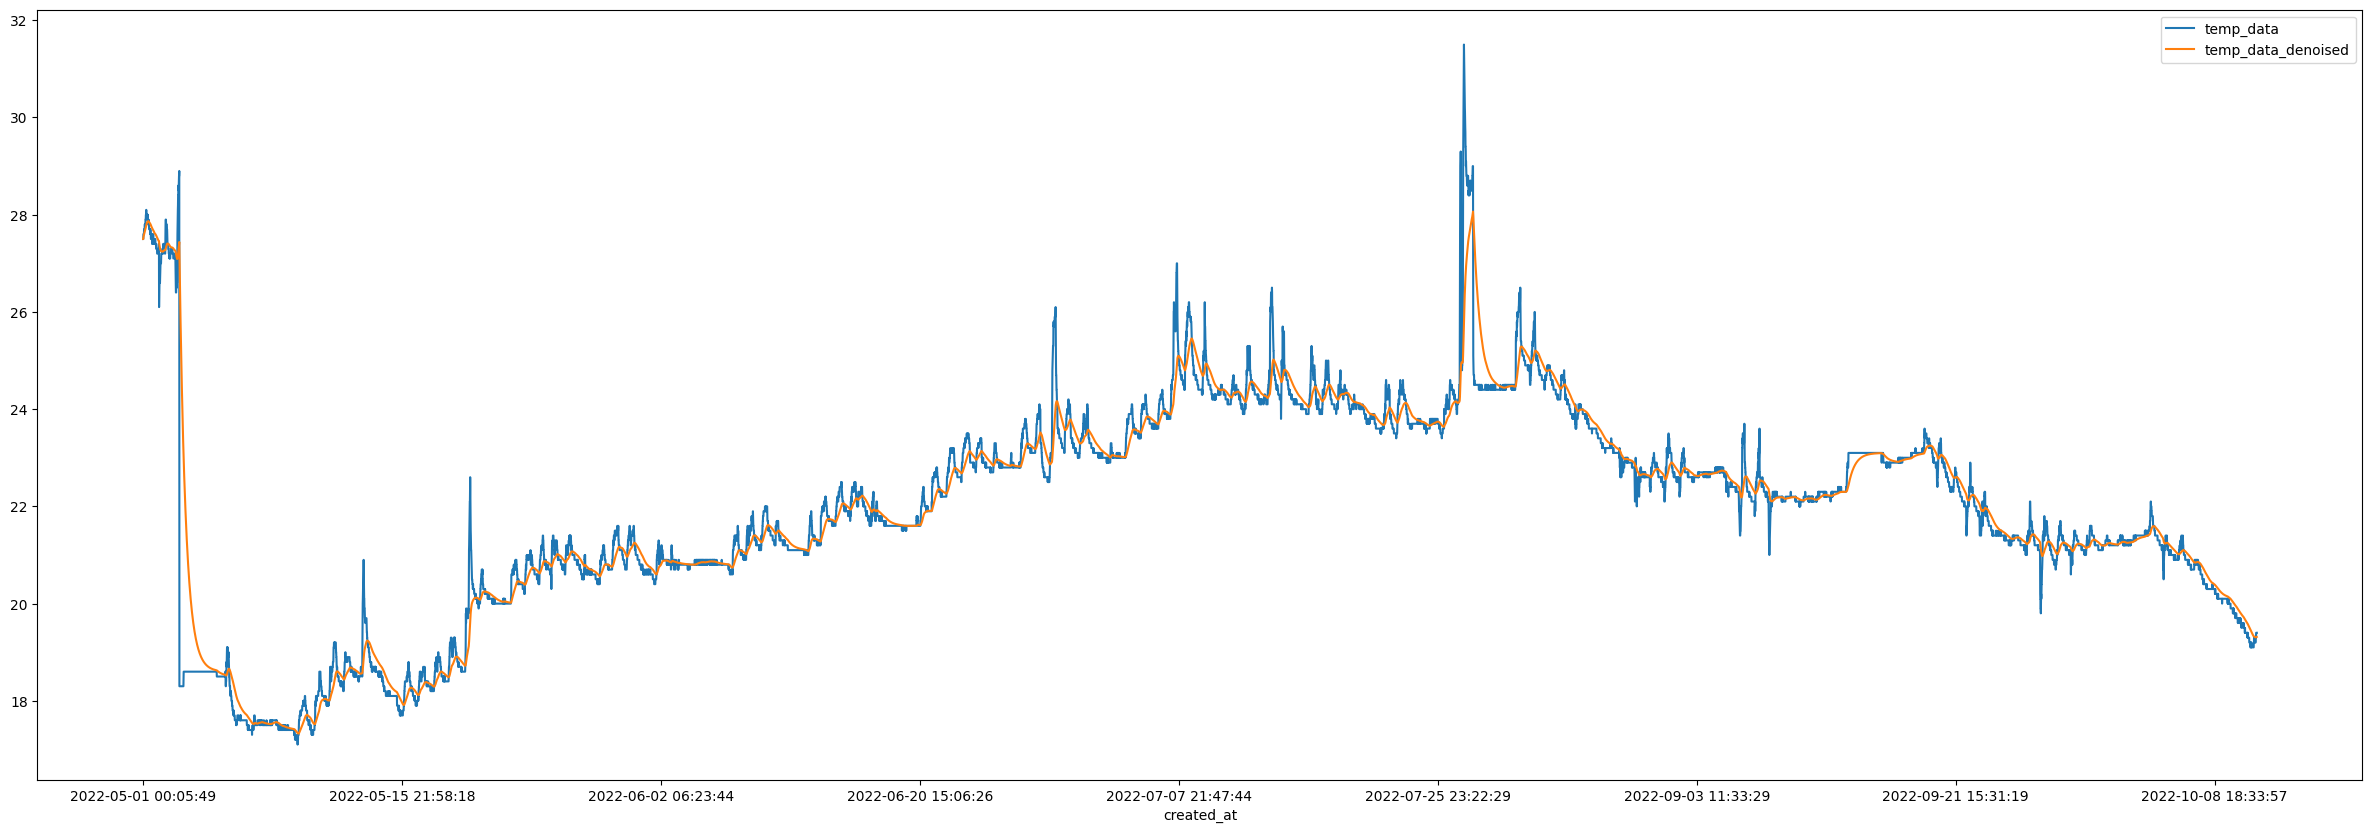

In [14]:
# temerature data
ema = pd.DataFrame(hr_sensor_data_value['temp_data']).ewm(com).mean()
hr_sensor_data_value_denoised['temp_data_denoised'] = ema['temp_data']
hr_sensor_data_value_denoised.plot(y=['temp_data', 'temp_data_denoised'], figsize=(30,10))


<AxesSubplot:xlabel='created_at'>

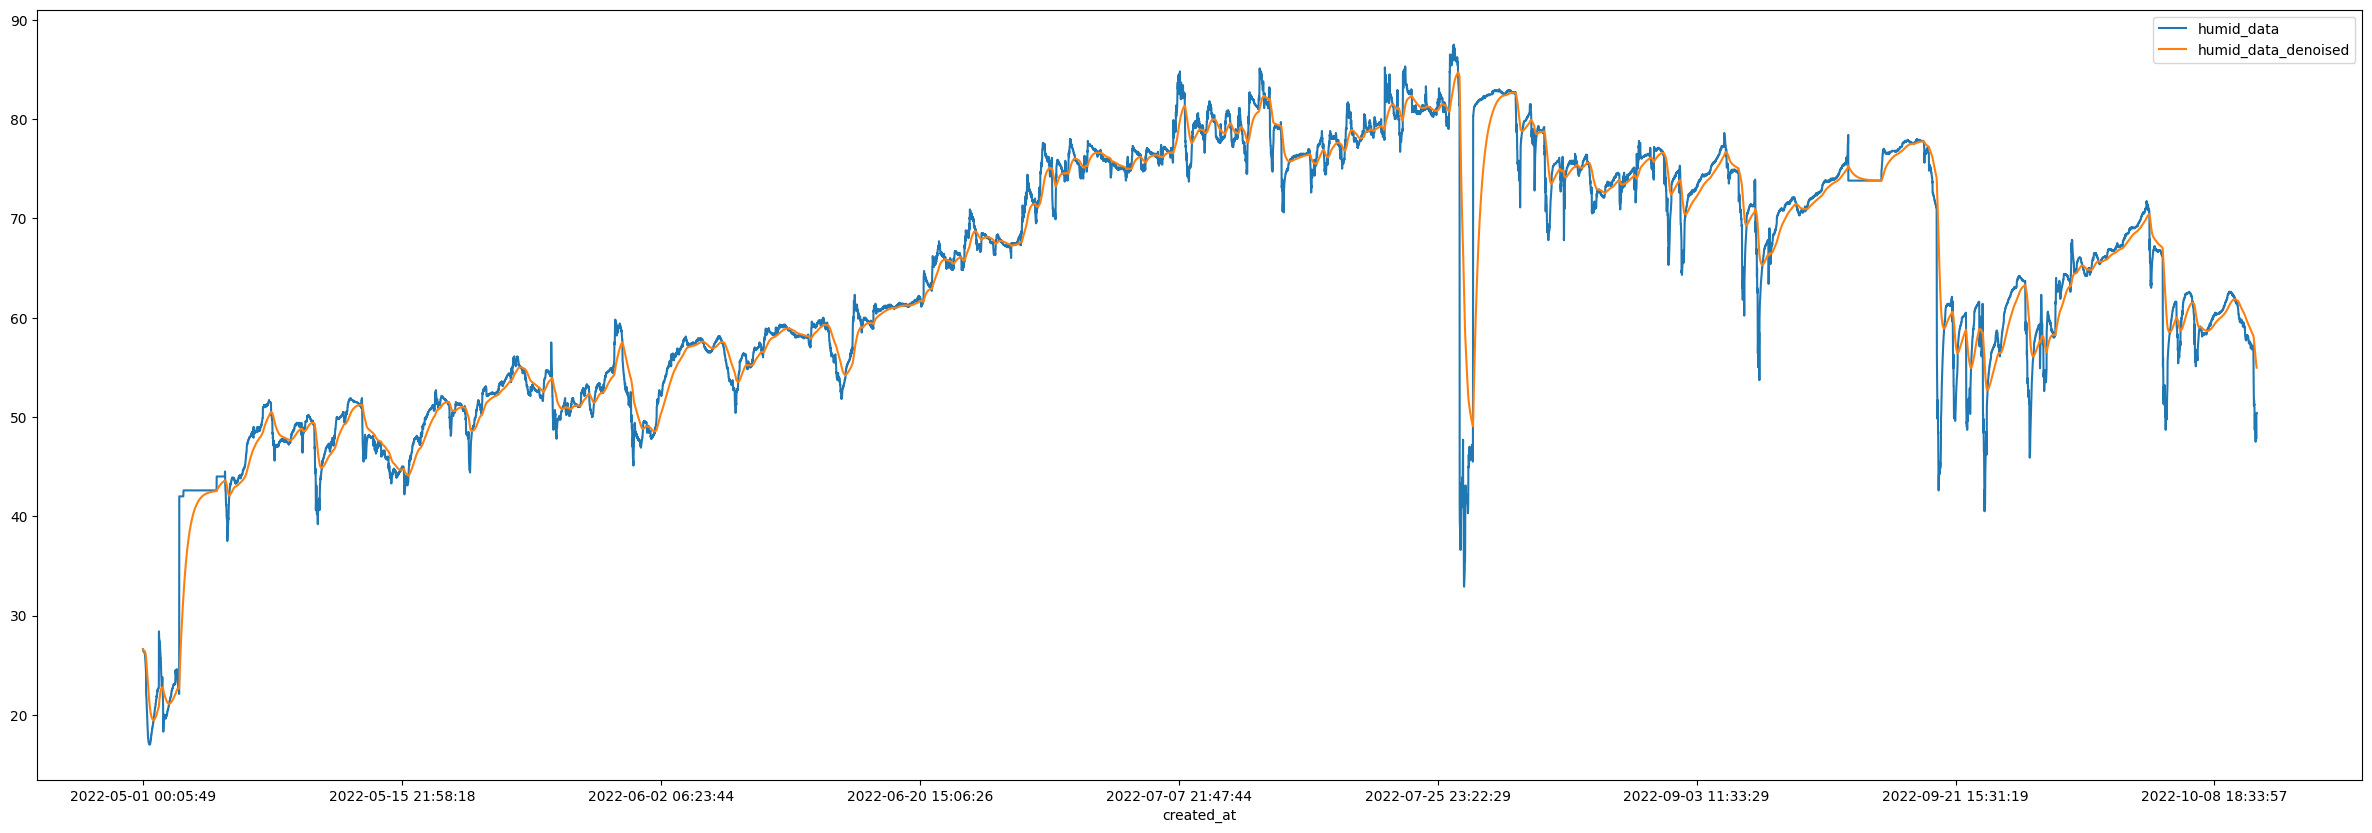

In [15]:
# humidity data
ema = pd.DataFrame(hr_sensor_data_value['humid_data']).ewm(com).mean()
hr_sensor_data_value_denoised['humid_data_denoised'] = ema['humid_data']
hr_sensor_data_value_denoised.plot(y=['humid_data', 'humid_data_denoised'], figsize=(30,10))


<AxesSubplot:xlabel='created_at'>

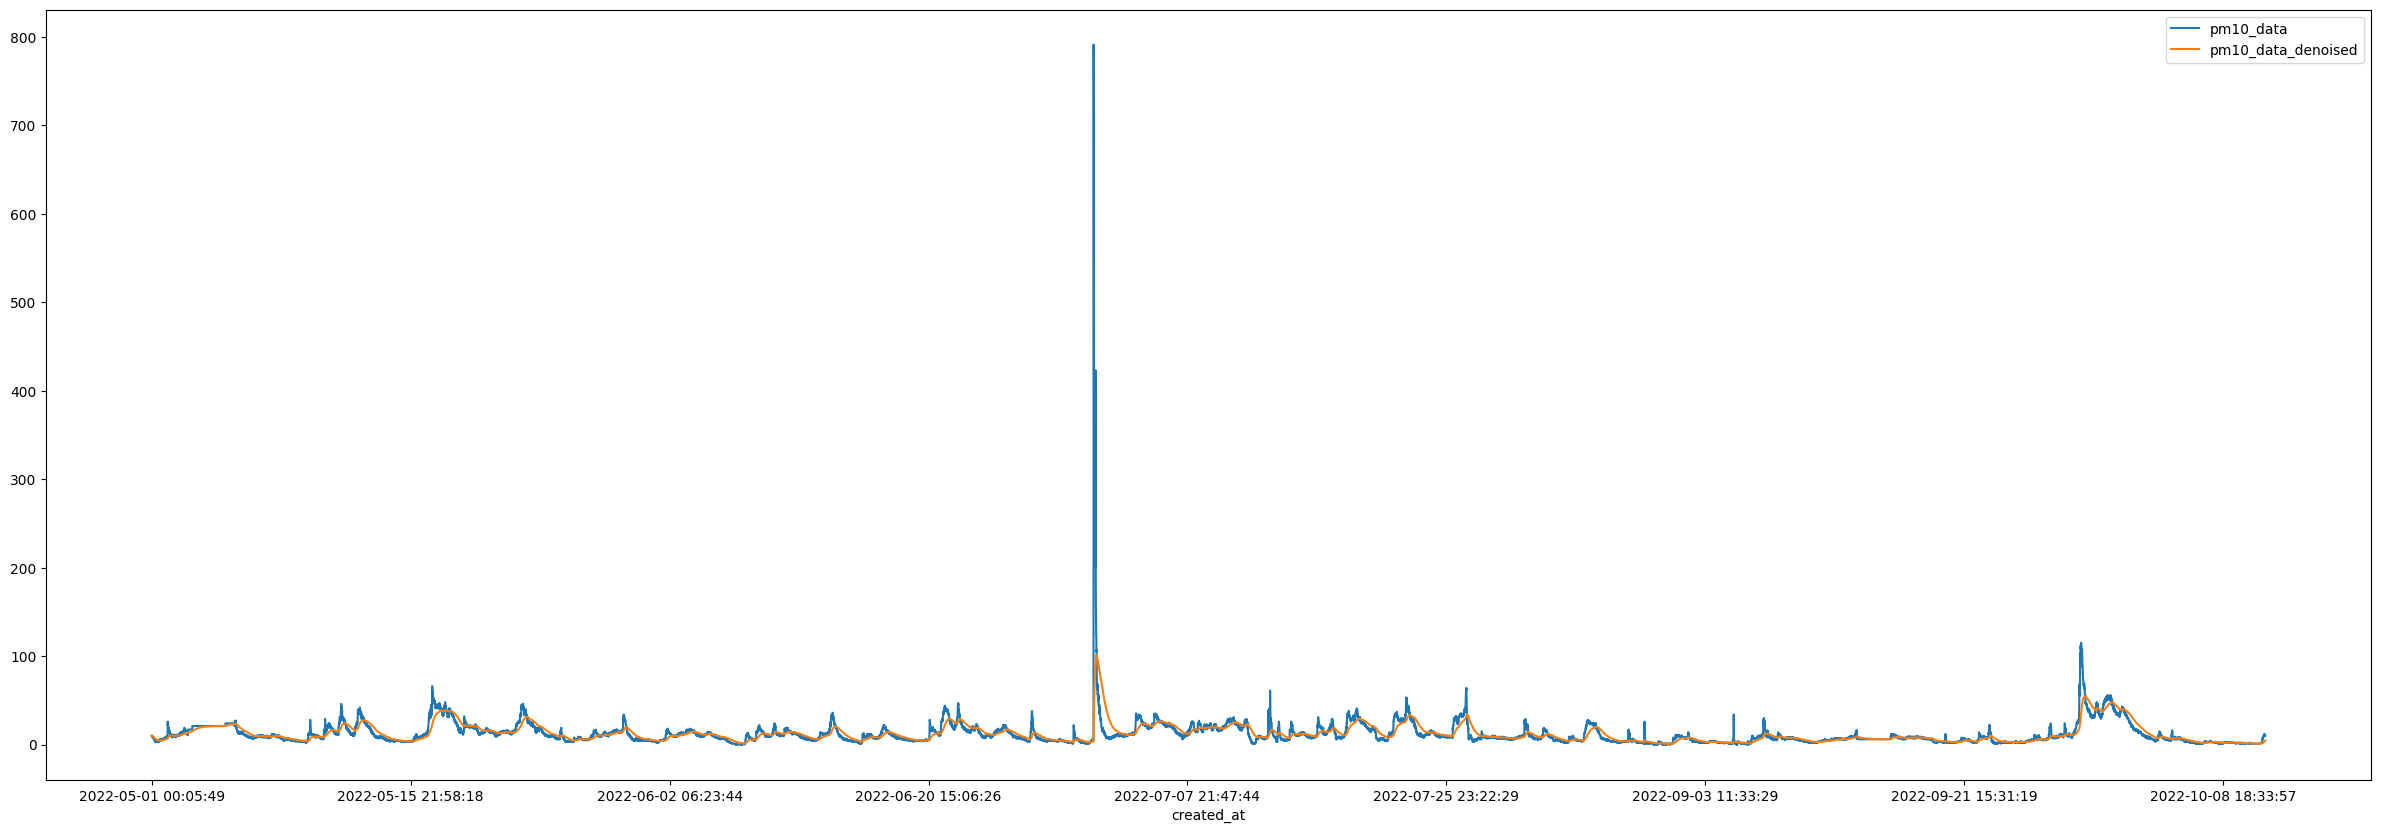

In [16]:
# pm10 data
ema = pd.DataFrame(hr_sensor_data_value['pm10_data']).ewm(com).mean()
hr_sensor_data_value_denoised['pm10_data_denoised'] = ema['pm10_data']
hr_sensor_data_value_denoised.plot(y=['pm10_data', 'pm10_data_denoised'], figsize=(30,10))


<AxesSubplot:xlabel='created_at'>

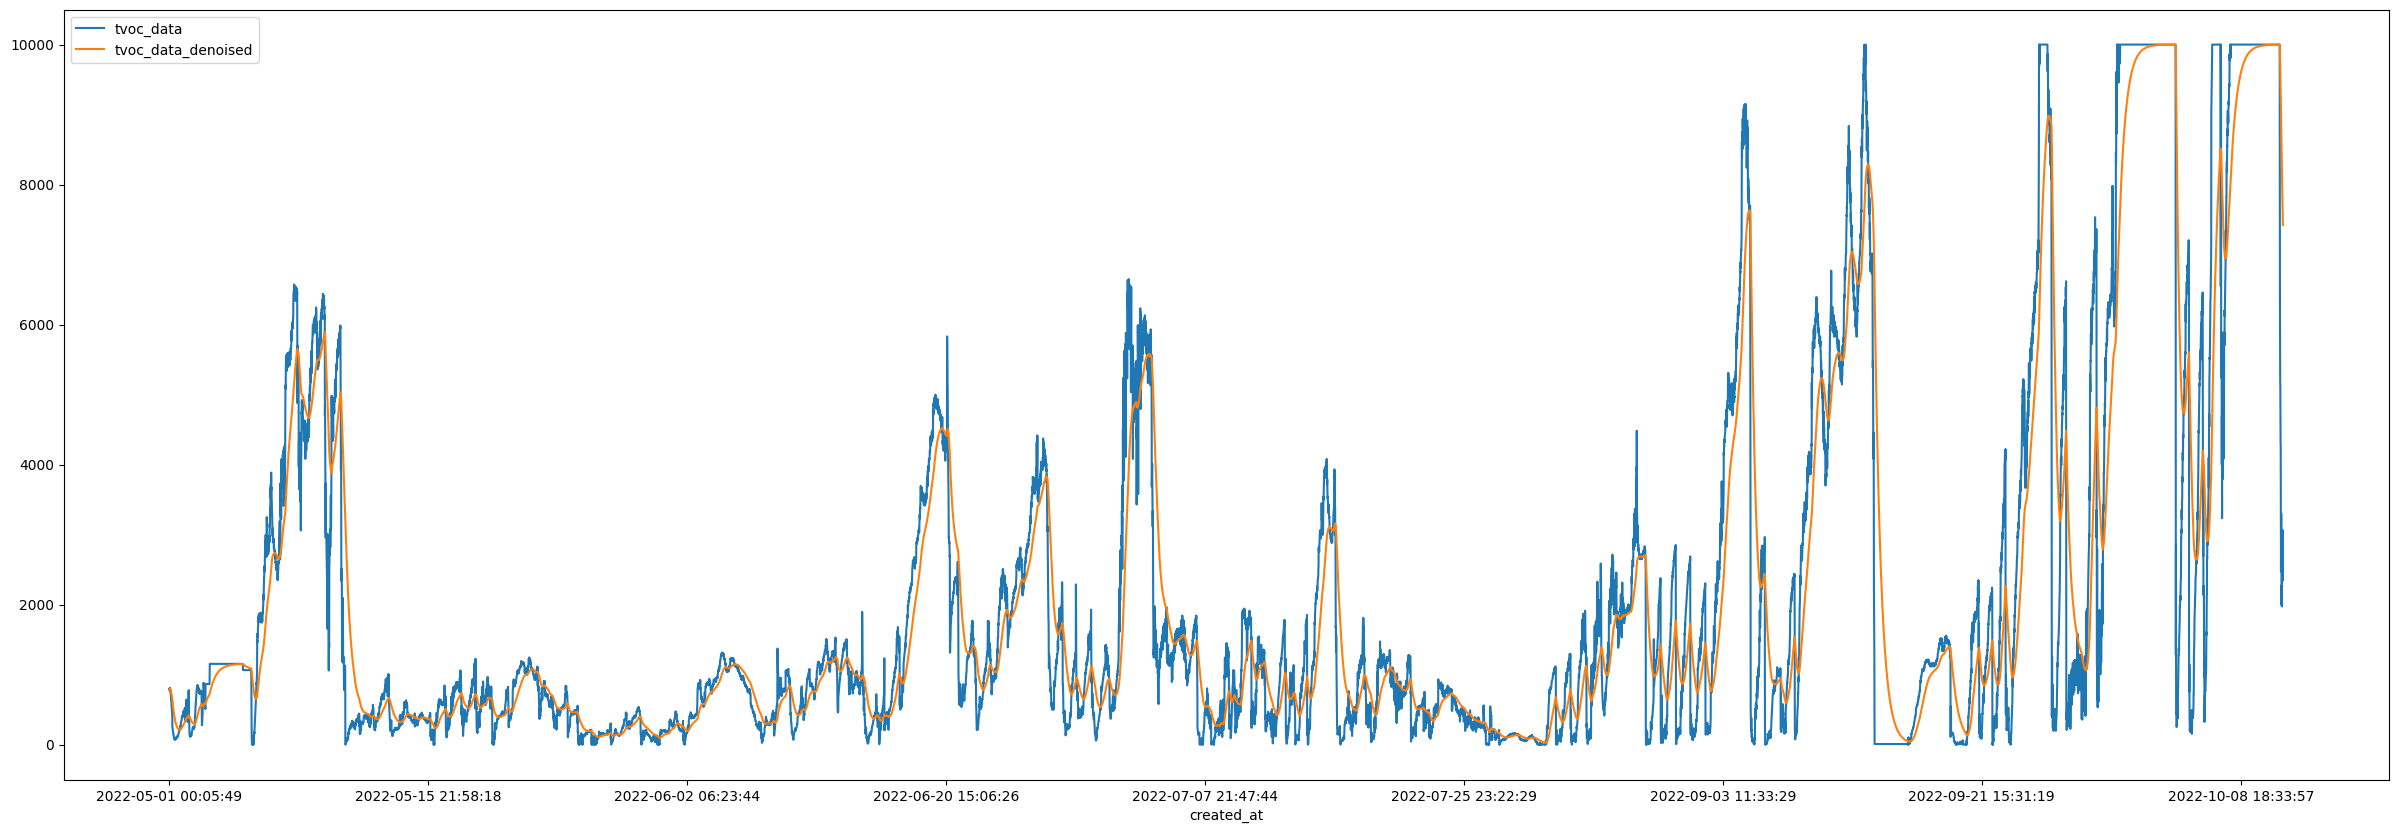

In [17]:
# tvoc data
ema = pd.DataFrame(hr_sensor_data_value['tvoc_data']).ewm(com).mean()
hr_sensor_data_value_denoised['tvoc_data_denoised'] = ema['tvoc_data']
hr_sensor_data_value_denoised.plot(y=['tvoc_data', 'tvoc_data_denoised'], figsize=(30,10))


In [18]:
print("co2 & temperature: {}".format(pearsonr(hr_sensor_data_value_denoised['co2_data_denoised'],hr_sensor_data_value_denoised['temp_data_denoised'])[0]))
print("co2 & humidity: {}".format(pearsonr(hr_sensor_data_value_denoised['co2_data_denoised'],hr_sensor_data_value_denoised['humid_data_denoised'])[0]))
print("co2 & pm10: {}".format(pearsonr(hr_sensor_data_value_denoised['co2_data_denoised'],hr_sensor_data_value_denoised['pm10_data_denoised'])[0]))
print("co2 & tvoc: {}".format(pearsonr(hr_sensor_data_value_denoised['co2_data_denoised'],hr_sensor_data_value_denoised['tvoc_data_denoised'])[0]))
print("temperature & humidity: {}".format(pearsonr(hr_sensor_data_value_denoised['temp_data_denoised'],hr_sensor_data_value_denoised['humid_data_denoised'])[0]))
print("temperature & pm10: {}".format(pearsonr(hr_sensor_data_value_denoised['temp_data_denoised'],hr_sensor_data_value_denoised['pm10_data_denoised'])[0]))
print("temperature & tvoc: {}".format(pearsonr(hr_sensor_data_value_denoised['temp_data_denoised'],hr_sensor_data_value_denoised['tvoc_data_denoised'])[0]))
print("humidity & pm10: {}".format(pearsonr(hr_sensor_data_value_denoised['humid_data_denoised'],hr_sensor_data_value_denoised['pm10_data_denoised'])[0]))
print("humidity & tvoc: {}".format(pearsonr(hr_sensor_data_value_denoised['humid_data_denoised'],hr_sensor_data_value_denoised['tvoc_data_denoised'])[0]))
print("pm10 & tvoc: {}".format(pearsonr(hr_sensor_data_value_denoised['pm10_data_denoised'],hr_sensor_data_value_denoised['tvoc_data_denoised'])[0]))


co2 & temperature: 0.11982579262891946
co2 & humidity: -0.0704687128680377
co2 & pm10: 0.34563281785203787
co2 & tvoc: -0.23362284067668798
temperature & humidity: 0.5624231893467178
temperature & pm10: -0.025085131875517818
temperature & tvoc: -0.2322514089669815
humidity & pm10: 0.04279990369972594
humidity & tvoc: 0.0525160479555033
pm10 & tvoc: -0.05601849142062013


In [19]:
print("co2 & temperature: {}".format(pearsonr(hr_sensor_data_value['co2_data'],hr_sensor_data_value['temp_data'])[0]))
print("co2 & humidity: {}".format(pearsonr(hr_sensor_data_value['co2_data'],hr_sensor_data_value['humid_data'])[0]))
print("co2 & pm10: {}".format(pearsonr(hr_sensor_data_value['co2_data'],hr_sensor_data_value['pm10_data'])[0]))
print("co2 & tvoc: {}".format(pearsonr(hr_sensor_data_value['co2_data'],hr_sensor_data_value['tvoc_data'])[0]))
print("temperature & humidity: {}".format(pearsonr(hr_sensor_data_value['temp_data'],hr_sensor_data_value['humid_data'])[0]))
print("temperature & pm10: {}".format(pearsonr(hr_sensor_data_value['temp_data'],hr_sensor_data_value['pm10_data'])[0]))
print("temperature & tvoc: {}".format(pearsonr(hr_sensor_data_value['temp_data'],hr_sensor_data_value['tvoc_data'])[0]))
print("humidity & pm10: {}".format(pearsonr(hr_sensor_data_value['humid_data'],hr_sensor_data_value['pm10_data'])[0]))
print("humidity & tvoc: {}".format(pearsonr(hr_sensor_data_value['humid_data'],hr_sensor_data_value['tvoc_data'])[0]))
print("pm10 & tvoc: {}".format(pearsonr(hr_sensor_data_value['pm10_data'],hr_sensor_data_value['tvoc_data'])[0]))


co2 & temperature: 0.12736644450869294
co2 & humidity: -0.11731121732579844
co2 & pm10: 0.23466366445416298
co2 & tvoc: -0.20780741376431877
temperature & humidity: 0.5400348864462136
temperature & pm10: -0.007943860091535231
temperature & tvoc: -0.2240637789866463
humidity & pm10: 0.03955560928989581
humidity & tvoc: 0.05807406570667886
pm10 & tvoc: -0.07137888494057998


In [20]:
hr_sensor_data_t_h_value_denoised = hr_sensor_data_value_denoised[["temp_data_denoised","humid_data_denoised"]]
hr_sensor_data_t_h_value_denoised.index=hr_sensor_data["created_at"]
hr_sensor_data_t_h_value_denoised

,temp_data_denoised,humid_data_denoised
created_at,,
2022-05-01 00:05:49,27.500000,26.600000
2022-05-01 00:15:49,27.500000,26.549505
2022-05-01 00:25:49,27.533996,26.532675
2022-05-01 00:35:49,27.550990,26.498515
2022-05-01 00:45:49,27.561184,26.478024
...,...,...
2022-10-11 13:24:55,19.307848,55.387516
2022-10-11 13:34:55,19.309655,55.238741
2022-10-11 13:44:55,19.311426,55.141903


In [29]:
train = hr_sensor_data_t_h_value_denoised.iloc[:-2000,:]
test = hr_sensor_data_t_h_value_denoised.iloc[-2000:,:]

<AxesSubplot:xlabel='created_at'>

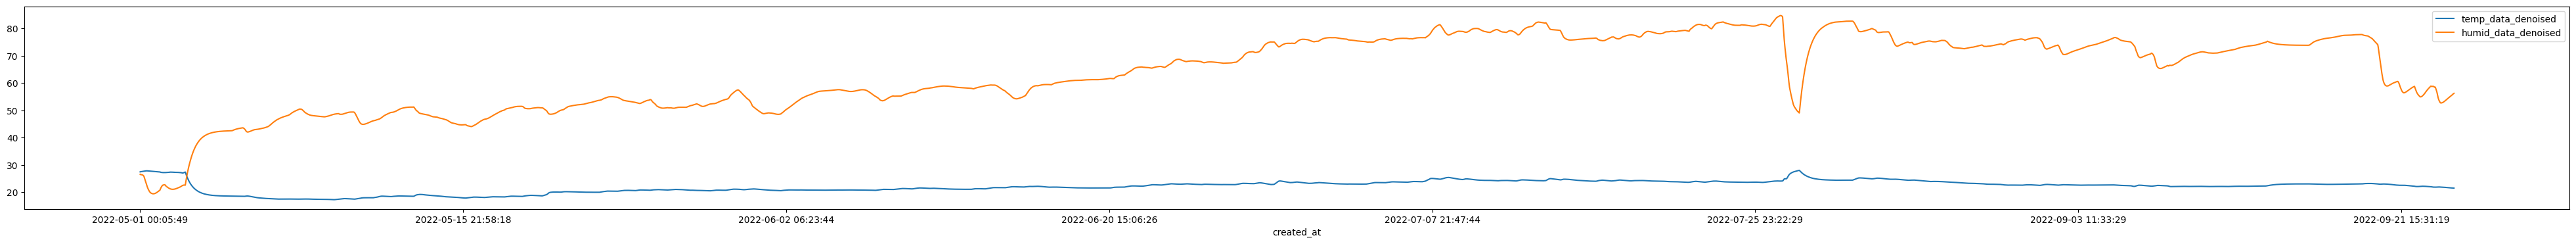

In [30]:
train.plot(figsize=(50,4))

In [31]:
forecasting_model = VAR(train)
results = forecasting_model.fit(2000)
results.summary()

/Users/seohyun/Desktop/KHU/capstone2/code/python-data-control/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 18, Oct, 2022
Time:                     22:39:19
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -16.9984
Nobs:                     12327.0    HQIC:                  -20.2013
Log likelihood:           107475.    FPE:                3.52460e-10
AIC:                     -21.8148    Det(Omega_mle):     2.00890e-10
--------------------------------------------------------------------
Results for equation temp_data_denoised
                               coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------------
const                             0.001078         0.000421            2.563           0.010
L1.temp_data_denoised             2.007808         0.011624          172.730           0.000

In [32]:
laaged_values = train.values[-2000:]
forecast = pd.DataFrame(results.forecast(y= laaged_values, steps=2000), index = test.index, columns= [['temp_data_denoised','humid_data_denoised']])
forecast

,temp_data_denoised,humid_data_denoised
created_at,,
2022-09-24 11:41:42,21.552244,56.239080
2022-09-24 11:51:42,21.547372,56.263630
2022-09-24 12:01:42,21.543099,56.291829
2022-09-24 12:11:42,21.538347,56.327081
2022-09-24 12:21:42,21.532807,56.353484
...,...,...
2022-10-11 13:24:55,20.968080,60.011330
2022-10-11 13:34:55,20.966222,60.035716
2022-10-11 13:44:55,20.964726,60.055030


/Users/seohyun/Desktop/KHU/capstone2/code/python-data-control/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/seohyun/Desktop/KHU/capstone2/code/python-data-control/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


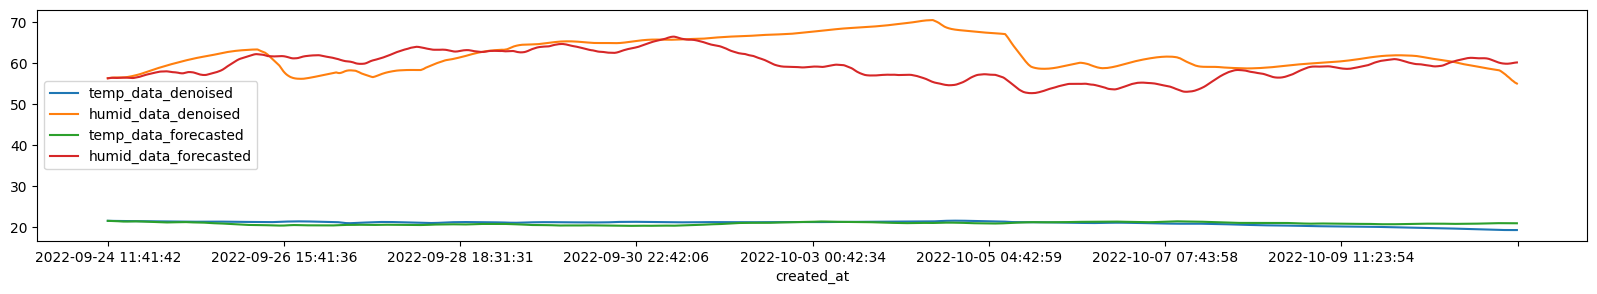

In [42]:
test["temp_data_forecasted"] = forecast["temp_data_denoised"]
test["humid_data_forecasted"] = forecast["humid_data_denoised"]
ax1 = test.plot(figsize=(20,3))


In [34]:
mean_squared_error(test["temp_data_forecasted"], test["temp_data_denoised"])

0.39968598154689905

In [35]:
mean_squared_error(test["humid_data_forecasted"], test["humid_data_denoised"])

30.79047880797936